# Landslide susceptibility

© 2024 Exneyder A. Montoya-Araque, Daniel F. Ruiz y Universidad EAFIT.

This notebook can be interactively run in [Google - Colab](https://colab.research.google.com/github/AppliedMechanics-EAFIT/EAFIT_slope_stability/blob/main/notebooks/01_cond_factors/landslide_susceptibility.ipynb).

This notebook evaluates susceptibility through the **information value method** and the proposed methodology by {cite:t}`Ciurleo_etal_2016_SusceptibilityZoningShallow` consisting of two steps. First, the production of a landslide susceptibility computational map, and second, the output of a susceptibility map for zoning purposes; in the latter, the terrain computational units (TCU) of the first map are aggregated into a larger terrain zoning unit (TZU).

The material used here has pedagogical-only purposes and was taken from the tutorial resources provided at the 2023 LAndslide Risk Assessment and Mitigation [-LARAM- school](https://www.laram.unisa.it/).

## Required modules and global setup for plots

In [1]:
import os
import sys
import shutil
import subprocess
from IPython import get_ipython

if 'google.colab' in str(get_ipython()):
    print('Running on CoLab. Installing the required modules...')
    from subprocess import run
    # run('pip install ipympl', shell=True);
    run('pip install rasterio', shell=True);
    from google.colab import output, files
    output.enable_custom_widget_manager()
else:
    import tkinter as tk
    from tkinter.filedialog import askopenfilename
    
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.metrics import roc_curve, roc_auc_score
import rasterio

# Figures setup
# %matplotlib widget
mpl.rcParams.update({
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman", "cmr", "cmr10", "DejaVu Serif"],  # or 
    "mathtext.fontset": "cm",  # Use Computer Modern fonts for math
    "axes.formatter.use_mathtext": True,  # Use mathtext for axis labels
    "axes.unicode_minus": False,   # Use standard minus sign instead of a unicode character
})
tol_cols = ["#004488", "#DDAA33", "#BB5566"]

n_classes = 8  # number of classes to divide the conditioning factors

## Functions

In [2]:
def load_tiff(path):
    with rasterio.open(path) as src:
        raster = src.read(1)
        raster[raster == src.nodata] = np.nan
        return raster, src.transform, src.crs, src.bounds
    
def plot_field(field, bounds, title=None, cmap='viridis'):
    fig, ax = plt.subplots()
    if len(np.unique(field)) > n_classes:  # Plot contours only if it's a continuous conditioning factor
        im = ax.imshow(field, cmap=cmap, extent=(bounds.left, bounds.right, bounds.bottom, bounds.top))
        ax.contour(field, colors='black', alpha=0.5, origin='image',
                extent=(bounds.left, bounds.right, bounds.bottom, bounds.top))
        cbar = plt.colorbar(mappable=im, ax=ax, label=title)
    if len(np.unique(field)) <= n_classes:
        field_r, ticks_r, cmap_r = extract_from_discrete(field, cmap)
        im = ax.imshow(field_r, cmap=cmap_r, extent=(bounds.left, bounds.right, bounds.bottom, bounds.top))
        cbar = plt.colorbar(mappable=im, ax=ax, label=title, ticks=ticks_r)
    fig.canvas.header_visible = False
    fig.canvas.toolbar_position = 'bottom'
    plt.show()
    return fig

def extract_from_discrete(field, cmap='viridis'):
    ticks = np.unique(field)[~np.isnan(np.unique(field))]  # For colorbar
    n = len(ticks)
    field_r = np.full_like(field, np.nan)  # Empty reclasified field
    ticks_r = np.arange(n)  # Ticks to use in reclasified field
    for i in ticks_r:  #  Fill reclasified field
        field_r[field == ticks[i]] = i
    cmap_r = plt.colormaps.get_cmap(cmap).resampled(n)  # type: ignore
    return field_r, ticks_r, cmap_r

def nan_gaussian_filter(data, sigma):
    nan_mask = np.isnan(data)

    # Replace NaNs with 0 for convolution
    data_filled = np.where(nan_mask, 0, data)

    # Create a weight mask of valid data
    weights = (~nan_mask).astype(float)

    # Apply Gaussian filter to data and weights
    data_filtered = sp.ndimage.gaussian_filter(data_filled, sigma=sigma, mode='constant', cval=0.0)
    weights_filtered = sp.ndimage.gaussian_filter(weights, sigma=sigma, mode='constant', cval=0.0)

    # Normalize the result
    with np.errstate(invalid='ignore', divide='ignore'):
        normalized = data_filtered / weights_filtered
        normalized[weights_filtered == 0] = np.nan  # Restore NaNs

    return normalized

## Reading the input data
If working on Google Colab, set the `testing_data` variable in the following cell as `False`. Then you will be asked to upload your own raster files.

In [3]:
testing_data = True  # Set to False to use the GUI to load the data from an external file

### Loading testing data

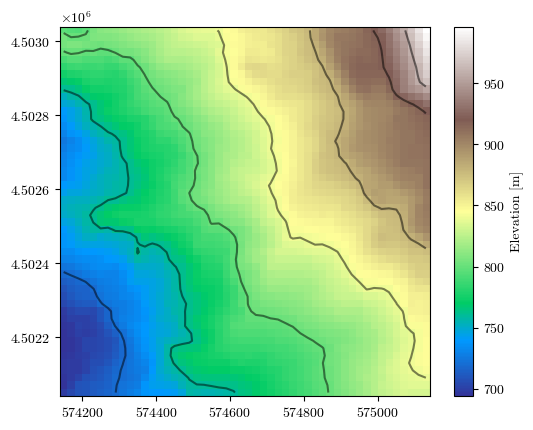

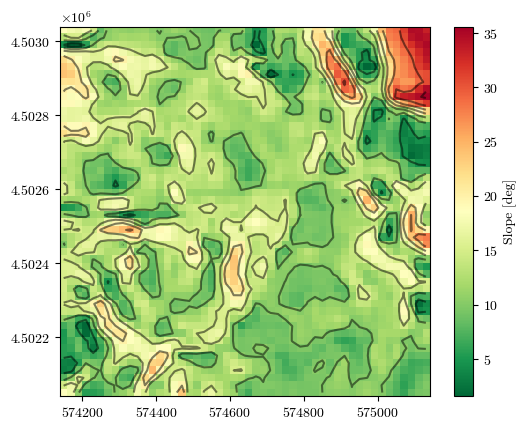

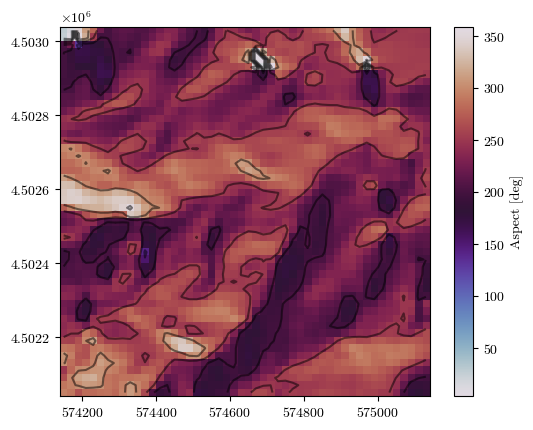

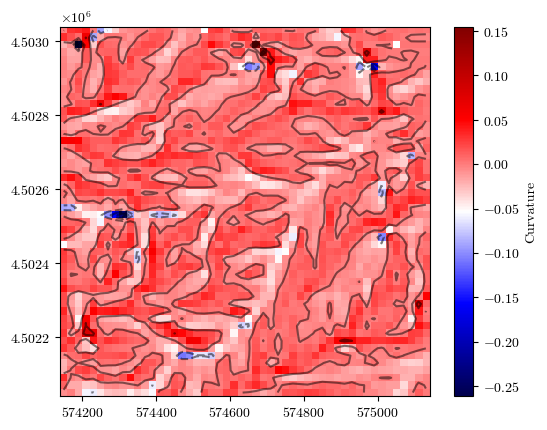

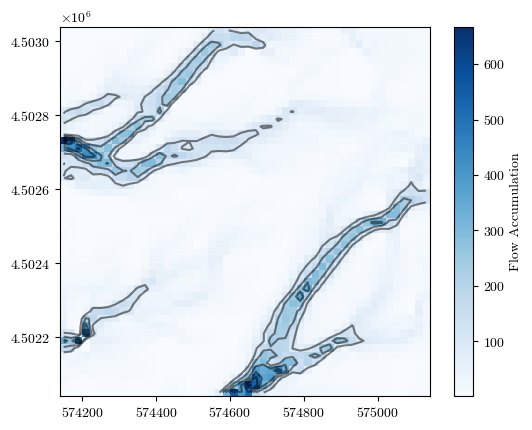

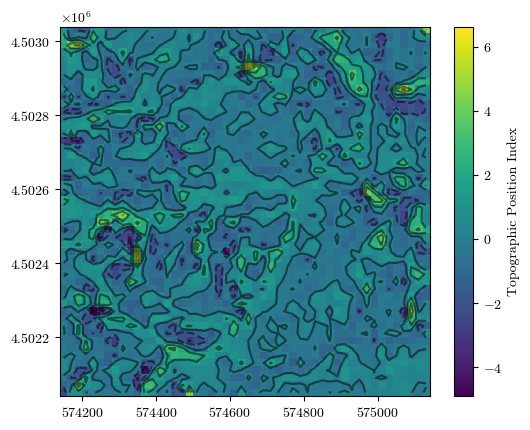

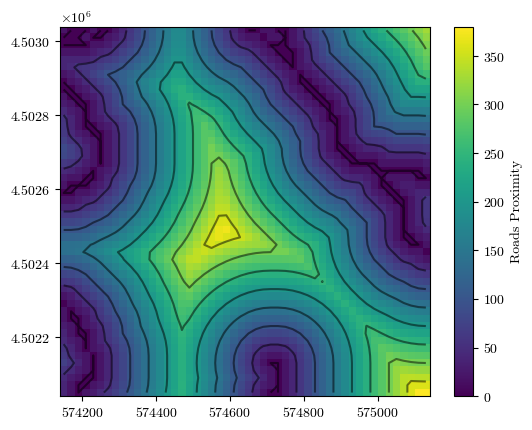

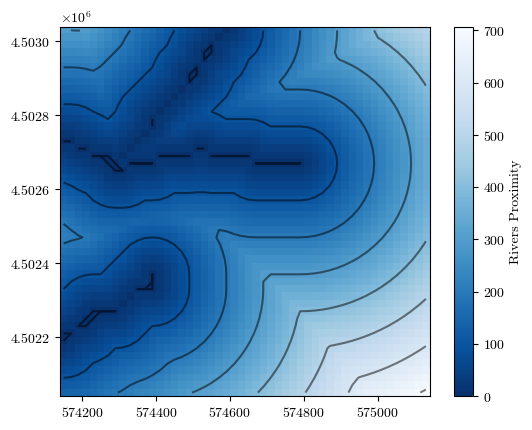

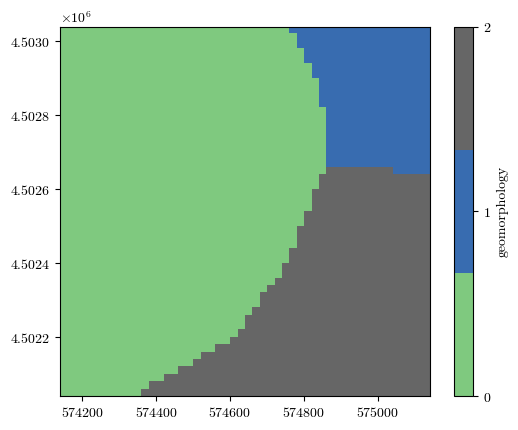

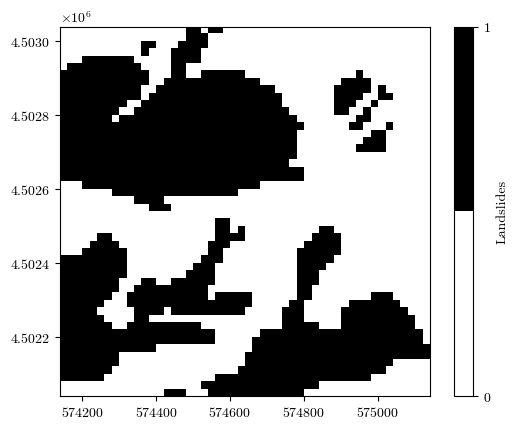

In [4]:
if testing_data:
    url = "https://github.com/eamontoyaa/data4testing/raw/refs/heads/main/susceptibility/"
    # Load the data (conditioning factors)
    elevation, transform, crs, bounds = load_tiff(f"{url}/elevation.tif")
    slope, _, _, _ = load_tiff(f"{url}/slope.tif")
    aspect, _, _, _ = load_tiff(f"{url}/aspect.tif")
    curvature, _, _, _ = load_tiff(f"{url}/curvature.tif")
    flow_acc, _, _, _ = load_tiff(f"{url}/flow_acc.tif")
    tpi, _, _, _ = load_tiff(f"{url}/tpi.tif")
    roads_prox, _, _, _ = load_tiff(f"{url}/roads_prox.tif")
    rivers_prox, _, _, _ = load_tiff(f"{url}/rivers_prox.tif")
    geomorphology, _, _, _ = load_tiff(f"{url}/geomorphology.tif")
    
    df_cond_fact = pd.DataFrame({
        'elevation': elevation.flatten(),
        'slope': slope.flatten(),
        'aspect': aspect.flatten(),
        'curvature': curvature.flatten(),
        'flow_acc': flow_acc.flatten(),
        'tpi': tpi.flatten(),
        'roads_prox': roads_prox.flatten(),
        'rivers_prox': rivers_prox.flatten(),
        'geomorphology': geomorphology.flatten(),
    })
    independent_vars = df_cond_fact.columns.to_list()
    independent_vars_types = ['c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'd']

    # Mask of NaN values for all the conditioning factors
    mask_nan = df_cond_fact.isna().any(axis=1)
    mask_nan_mtx = mask_nan.values.reshape(elevation.shape)

    # Landslides
    landslides, _, _, _ = load_tiff(f"{url}/landslides.tif")
    landslides[np.isnan(landslides)] = 0
    landslides[mask_nan_mtx] = np.nan
    df_landslides = pd.Series(landslides.flatten())

    # Plot the data
    fig = plot_field(elevation, bounds, title='Elevation [m]', cmap='terrain')
    fig = plot_field(slope, bounds, title='Slope [deg]', cmap='RdYlGn_r')
    fig = plot_field(aspect, bounds, title='Aspect [deg]', cmap='twilight')
    fig = plot_field(curvature, bounds, title='Curvature', cmap='seismic')
    fig = plot_field(flow_acc, bounds, title='Flow Accumulation', cmap='Blues')
    fig = plot_field(tpi, bounds, title='Topographic Position Index', cmap='viridis')
    fig = plot_field(roads_prox, bounds, title='Roads Proximity', cmap='viridis')
    fig = plot_field(rivers_prox, bounds, title='Rivers Proximity', cmap='Blues_r')
    fig = plot_field(geomorphology, bounds, title='geomorphology', cmap='Accent')
    fig = plot_field(landslides, bounds, title='Landslides', cmap='binary')


### Uploading the raster files of conditioning factors

In [5]:
if testing_data is False and 'google.colab' in str(get_ipython()):
    df_cond_fact = pd.DataFrame()
    cond_factors_files = files.upload()
    for file in cond_factors_files:
        file_name = file.split('.')[0].split(' ')[0]
        raster, transform, crs, bounds = load_tiff(file)
        fig = plot_field(raster, bounds, title=file_name)
        df_cond_fact[file_name] = raster.flatten()
    independent_vars = df_cond_fact.columns.to_list()
    independent_vars_types = ['c']*len(independent_vars)
    # If unique values are less than or equal to n_classes, then it is a discrete variable
    for idx, col in enumerate(independent_vars):
        if len(df_cond_fact[col].unique()) <= n_classes:
            independent_vars_types[idx] = 'd'

    # Mask of NaN values for all the conditioning factors
    mask_nan = df_cond_fact.isna().any(axis=1)
    mask_nan_mtx = mask_nan.values.reshape(raster.shape)
    


### Uploading the raster files of landslides 

In [6]:
if testing_data is False and 'google.colab' in str(get_ipython()):
    landslides_file = files.upload()
    landslides, transform, crs, bounds = load_tiff(list(landslides_file.keys())[0])
    landslides[np.isnan(landslides)] = 0
    landslides[mask_nan_mtx] = np.nan
    fig = plot_field(landslides, bounds, title='Landslides', cmap='binary')
    df_landslides = pd.Series(landslides.flatten())
    df_landslides.loc[mask_nan] = np.nan


In [28]:
mask_nan_cond_fact = df_cond_fact.isna().any(axis=1)
mask_nan_landslides = df_landslides.isna()
mask_nan = mask_nan_cond_fact | mask_nan_landslides
# Replace the NaN values in the conditioning factors and landslides with NaN
df_cond_fact.loc[mask_nan] = np.nan
df_landslides.loc[mask_nan] = np.nan

In [7]:
df_cond_fact

,elevation,slope,aspect,curvature,flow_acc,tpi,roads_prox,rivers_prox,geomorphology
0,797.760010,18.761023,27.847687,-0.00147,2.12,1.128723,20.0,300.000000,1.0
1,794.750000,17.574442,15.301435,0.03129,3.20,-0.911255,0.0,300.000000,1.0
2,794.169983,17.088249,348.047455,0.03405,5.56,-1.530029,0.0,300.665924,1.0
3,797.669983,17.850204,311.438507,0.04068,3.59,-1.732483,0.0,297.321381,1.0
4,805.789978,14.410152,279.945099,0.00059,1.69,1.342468,20.0,284.253418,1.0
...,...,...,...,...,...,...,...,...,...
2495,831.929993,7.303904,235.462631,-0.03553,2.60,0.393738,320.0,672.309448,3.0
2496,833.359985,6.323634,200.697632,-0.03034,2.37,0.659973,340.0,680.294067,3.0
2497,833.030029,8.246736,176.506042,-0.00403,4.16,0.075073,360.0,688.767029,3.0
2498,832.500000,9.393118,181.905396,0.01264,7.15,-0.397461,380.0,697.710571,3.0


In [8]:
independent_vars_types

['c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'd']

In [9]:
df_landslides

0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
2495    0.0
2496    0.0
2497    0.0
2498    0.0
2499    0.0
Length: 2500, dtype: float32

## Percentile class for each independent variable

The independent variables are classified according to a quantile criterion employing 8 classes

In [10]:
percentages = np.linspace(0, 100, n_classes+1)  # percentages for the percentiles to compute
df_cond_fact_p = df_cond_fact.copy()

for n_iv, iv in enumerate(independent_vars): # Variable whose percentiles is being classified
    p_class = np.full_like(df_landslides.to_numpy(), fill_value=-1, dtype=int)  # percentile classes
    if independent_vars_types[n_iv] == 'c':
        percentiles = np.nanpercentile(df_cond_fact[iv], percentages, method='linear')  # percentiles that limit the clases
        for p in np.arange(n_classes):
            p_class[df_cond_fact[iv].to_numpy() >= percentiles[p]] = p
    elif independent_vars_types[n_iv] == 'd':
        uvals = np.unique(df_cond_fact[iv])
        for n_uval, uval in enumerate(uvals):
            p_class[df_cond_fact[iv] == uval] = n_uval
    if any(p_class == -1):
        n_unclass = np.sum(p_class==-1) 
        print(f"There are {n_unclass} TCUs in the '{iv}' independent variable without percentile classification")
    df_cond_fact_p[iv] = p_class  # This plus one is to math the tutorial nomenclature

df_cond_fact_p

There are 2 TCUs in the 'elevation' independent variable without percentile classification
There are 2 TCUs in the 'slope' independent variable without percentile classification
There are 2 TCUs in the 'aspect' independent variable without percentile classification
There are 2 TCUs in the 'curvature' independent variable without percentile classification
There are 2 TCUs in the 'flow_acc' independent variable without percentile classification
There are 2 TCUs in the 'tpi' independent variable without percentile classification
There are 2 TCUs in the 'roads_prox' independent variable without percentile classification
There are 2 TCUs in the 'rivers_prox' independent variable without percentile classification
There are 2 TCUs in the 'geomorphology' independent variable without percentile classification


,elevation,slope,aspect,curvature,flow_acc,tpi,roads_prox,rivers_prox,geomorphology
0,3,7,0,3,0,7,0,6,0
1,3,7,0,7,0,1,0,6,0
2,3,6,7,7,1,0,0,6,0
3,3,7,7,7,1,0,0,5,0
4,3,5,7,3,0,7,0,5,0
...,...,...,...,...,...,...,...,...,...
2495,5,0,3,0,0,5,7,7,2
2496,5,0,0,0,0,6,7,7,2
2497,5,0,0,2,1,4,7,7,2
2498,5,1,0,6,2,2,7,7,2


### $N_{ij} = F_{ij} + NF_{ij}$ → TCUs belonging to the class $j$ of the independent variable $V_i$

- $F_{ij}$ → Number of TCUs with landslides belonging to the class $j$ of the independent variable $V_i$
- $NF_{ij}$ → Number of TCUs without landslides belonging to the class $j$ of the independent variable $V_i$

In [11]:
# number of TCUs with landslides belonging to the class j of the independent variable Vi
Fij = np.zeros((n_classes, len(independent_vars)))
# number of TCUs without landslides belonging to the class j of the independent variable Vi
NFij = np.zeros((n_classes, len(independent_vars)))

for i in np.arange(n_classes):  # iterate over percentile classes (rows)
    for j, iv in enumerate(independent_vars): # iterate over IV classes (columns)
        Fij[i, j] = np.nansum(np.logical_and(df_cond_fact_p[iv]==i, df_landslides==1))
        NFij[i, j] = np.nansum(np.logical_and(df_cond_fact_p[iv]==i, df_landslides==0))

# number of TCUs belonging to the class j of the independent variable Vi
Nij = Fij + NFij

pd.DataFrame(Nij, columns=independent_vars, index=[f'Class {i}' for i in np.arange(n_classes)])

,elevation,slope,aspect,curvature,flow_acc,tpi,roads_prox,rivers_prox,geomorphology
Class 0,313.0,313.0,313.0,312.0,312.0,313.0,291.0,264.0,1493.0
Class 1,312.0,312.0,312.0,313.0,312.0,312.0,289.0,356.0,297.0
Class 2,312.0,312.0,312.0,312.0,313.0,310.0,284.0,299.0,708.0
Class 3,312.0,312.0,312.0,311.0,312.0,314.0,372.0,324.0,0.0
Class 4,312.0,312.0,312.0,312.0,312.0,312.0,325.0,301.0,0.0
Class 5,312.0,312.0,312.0,313.0,312.0,312.0,309.0,314.0,0.0
Class 6,311.0,312.0,312.0,312.0,312.0,312.0,295.0,325.0,0.0
Class 7,314.0,313.0,313.0,313.0,313.0,313.0,333.0,315.0,0.0


### $W_{ij} = \log\left(\frac{D_{ij}}{D^*}\right)$ → Weight of the class $j$ of the independent variable $V_i$

- $D_{ij} =\frac{F_{ij}}{N_{ij}}$ → Density of landslides within class $j$ of the independent variable $V_i$
- $D^* = \frac{F_\mathrm{tot}}{N_\mathrm{tot}}$ → Average density of landslides within the test area

In [12]:
Dij = Fij / Nij
Ftot = np.nansum(Fij, axis=0)
NFtot = np.nansum(NFij, axis=0)
Ntot = Ftot + NFtot
Dast = Ftot / Ntot
Wij = np.log10(Dij / Dast)
# Correct weight where no landslides occurred
Wij_inf = np.isinf(Wij)
Wij[Wij_inf] = np.floor(np.nanmin(Wij[~Wij_inf]))

pd.DataFrame(Wij, columns=independent_vars, index=[f'Class {i}' for i in np.arange(n_classes)])

/tmp/ipykernel_74290/3450856213.py:1: RuntimeWarning: invalid value encountered in divide
  Dij = Fij / Nij


,elevation,slope,aspect,curvature,flow_acc,tpi,roads_prox,rivers_prox,geomorphology
Class 0,0.185269,-0.046799,-0.105777,-0.270719,-0.502328,0.048730,-0.086135,0.255150,0.081188
Class 1,0.076936,0.063735,0.021537,-0.097952,-0.132943,0.036063,-0.001934,0.213565,-0.544598
Class 2,0.159571,0.050119,-0.018675,-0.005901,-0.151535,0.035990,0.008999,0.068603,-0.062326
Class 3,0.074328,0.063735,-0.015446,-0.033796,-0.070233,0.091994,-0.031837,-0.112953,NaN
Class 4,0.094769,0.044552,-0.045410,0.038911,0.018573,0.003439,0.037888,-0.238097,NaN
Class 5,0.018573,0.018573,-0.035190,0.070314,0.097258,-0.012241,0.043107,-0.424279,NaN
Class 6,-0.940266,-0.031837,0.092266,0.074328,0.135253,-0.041976,0.060396,-0.312251,NaN
Class 7,-0.617076,-0.233356,0.072938,0.112901,0.238436,-0.233356,-0.043736,0.093102,NaN


### $IS_\mathrm{TCU} = \sum_{i=0}^{n-1} W_{ik_{(i)}} $ → Susceptibility index

In [13]:
df_cond_fact_w = df_cond_fact_p.copy()
for j, iv in enumerate(independent_vars): # iterate over independent variables (columns)
    df_cond_fact_w[iv] = Wij[df_cond_fact_p[iv], j]
df_cond_fact_w.loc[mask_nan] = np.nan
df_cond_fact_w["ISTCU"] = df_cond_fact_w.sum(axis=1)
df_cond_fact_w.loc[mask_nan, "ISTCU"] = np.nan
df_cond_fact_w

,elevation,slope,aspect,curvature,flow_acc,tpi,roads_prox,rivers_prox,geomorphology,ISTCU
0,0.074328,-0.233356,-0.105777,-0.033796,-0.502328,-0.233356,-0.086135,-0.312251,0.081188,-1.351483
1,0.074328,-0.233356,-0.105777,0.112901,-0.502328,0.036063,-0.086135,-0.312251,0.081188,-0.935365
2,0.074328,-0.031837,0.072938,0.112901,-0.132943,0.048730,-0.086135,-0.312251,0.081188,-0.173080
3,0.074328,-0.233356,0.072938,0.112901,-0.132943,0.048730,-0.086135,-0.424279,0.081188,-0.486628
4,0.074328,0.018573,0.072938,-0.033796,-0.502328,-0.233356,-0.086135,-0.424279,0.081188,-1.032867
...,...,...,...,...,...,...,...,...,...,...
2495,0.018573,-0.046799,-0.015446,-0.270719,-0.502328,-0.012241,-0.043736,0.093102,-0.062326,-0.841921
2496,0.018573,-0.046799,-0.105777,-0.270719,-0.502328,-0.041976,-0.043736,0.093102,-0.062326,-0.961987
2497,0.018573,-0.046799,-0.105777,-0.005901,-0.132943,0.003439,-0.043736,0.093102,-0.062326,-0.282369
2498,0.018573,0.063735,-0.105777,0.074328,-0.151535,0.035990,-0.043736,0.093102,-0.062326,-0.077647


## $\sigma_i$ → statistical indicator to assess the discriminant capability of $W_i$

In [14]:
n = np.sum(~np.isnan(Wij), axis=0)  # Number of classes of the independent variable Vi
Wij_ast = Wij * Nij / (Ntot / n)  # normalized value of the weight assigned to the class j of the independent variable Vi
Wi = np.nanmean(Wij, axis=0)  # average value of the weights assigned to the classes of the independent variable Vi
sigma = np.sqrt(np.nansum((Wij_ast - Wi)**2, axis=0) / (n - 1))

pd.DataFrame([sigma], columns=independent_vars, index=['sigma'])

,elevation,slope,aspect,curvature,flow_acc,tpi,roads_prox,rivers_prox,geomorphology
sigma,0.419273,0.10016,0.064685,0.123769,0.228635,0.099654,0.048868,0.25195,0.243137


/tmp/ipykernel_74290/1568106826.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(independent_vars, rotation=45, ha='right')


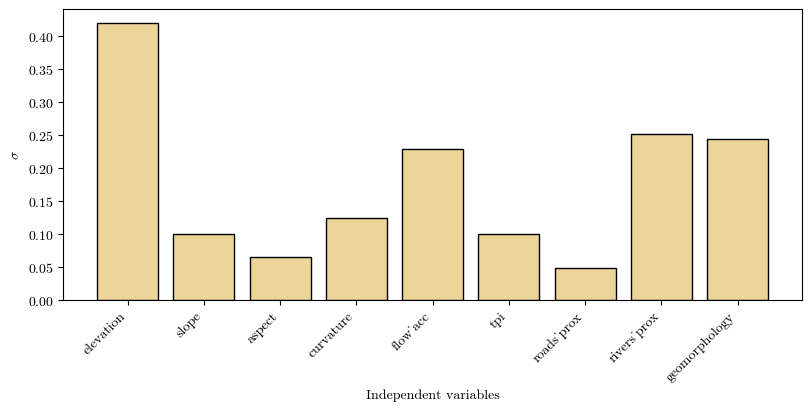

In [15]:
# Bar plot representing sigma
fig, ax = plt.subplots(figsize=(8, 4), layout='constrained')
ax.bar(independent_vars, sigma, color=mpl.colors.to_rgba(tol_cols[1], alpha=0.5), edgecolor='black')
ax.set(ylabel='$\\sigma$', xlabel='Independent variables')
# rotate x labels
ax.set_xticklabels(independent_vars, rotation=45, ha='right')
fig.canvas.header_visible = False
fig.canvas.toolbar_position = 'bottom'
plt.show()

## Visualize the spatial distribution of the susceptibility index

### Raw results for terrain computational units (TCU)

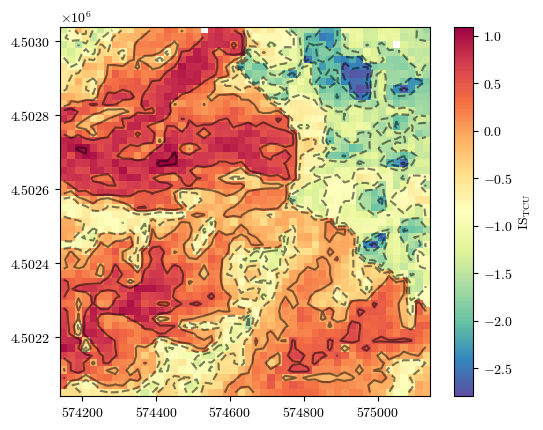

In [16]:
ISTCU = np.reshape(df_cond_fact_w['ISTCU'].to_numpy(), landslides.shape)

fig = plot_field(ISTCU, bounds, title='IS$_\\mathrm{TCU}$', cmap='Spectral_r')


### Processed results for larger terrain zoning unit (TZU)

The focal statistics used here is a 2D Gaussian filter with standard deviation $\sigma$ used to control the degree of smoothness.

To visualize the landslide boundaries over the map, uncomment the code in the following cell.

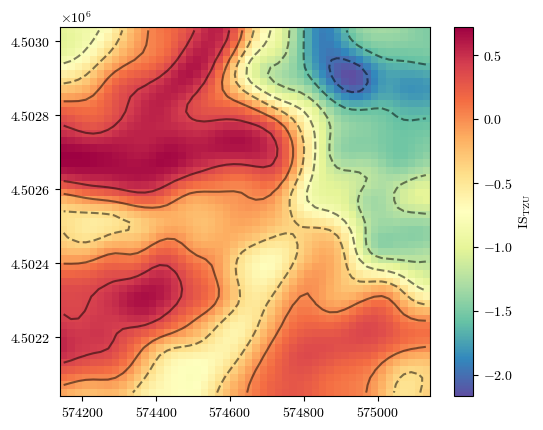

In [20]:
# ISTZU = sp.ndimage.gaussian_filter(ISTCU, sigma=1)
ISTZU = nan_gaussian_filter(ISTCU, sigma=2)

mask_nan_border = np.isnan(ISTZU).flatten()
df_cond_fact_w["ISTZU"] = ISTZU.flatten()

fig = plot_field(ISTZU, bounds, title='IS$_\\mathrm{TZU}$', cmap='Spectral_r')

# ax = fig.gca()
# ax.contour(landslides, colors='black', alpha=0.5, origin='image', levels=0, linewidths=5,
#            extent=(bounds.left, bounds.right, bounds.bottom, bounds.top))

### Export results to raster file

To save the susceptibility index map to a raster file, set the ``want2save`` variable in the next cell as `True`.

In [21]:
want2save = False

if want2save:
    spatial_data_path = os.path.join(os.getcwd(), 'spatial_data')
    src = list(landslides_file.keys())[0]
    dst = "ISTZU.tif"
    shutil.copy(src, dst)
    # Open the new raster in write mode
    with rasterio.open(dst, 'r+') as dst:
        dst.write(ISTZU, 1)  # Replace the existing array with the modified array

## Performance validation of the susceptibility model

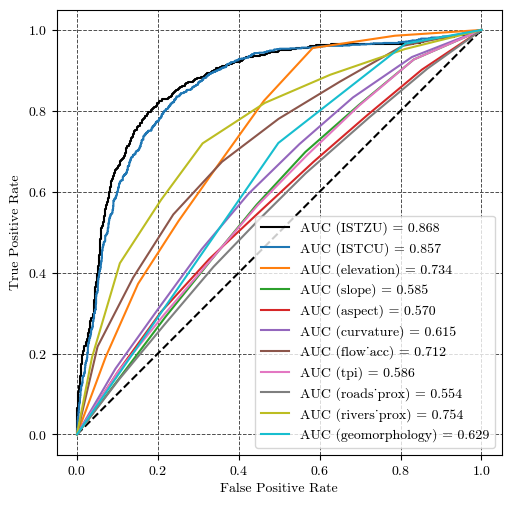

In [32]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(5, 5), layout='constrained')
plt.plot([0, 1], [0, 1], 'k--')

fpr, tpr, thresholds = roc_curve(df_landslides.loc[~mask_nan], df_cond_fact_w.loc[~mask_nan, "ISTZU"])  # Calculate the ROC curve
auc_score = roc_auc_score(df_landslides.loc[~mask_nan], df_cond_fact_w.loc[~mask_nan, "ISTZU"])  # Calculate the AUC score
ax.plot(fpr, tpr, label=f'AUC (ISTZU) = {auc_score:.3f}', c='k')

fpr, tpr, thresholds = roc_curve(df_landslides[~mask_nan], df_cond_fact_w.loc[~mask_nan, "ISTCU"])  # Calculate the ROC curve
auc_score = roc_auc_score(df_landslides[~mask_nan], df_cond_fact_w.loc[~mask_nan, "ISTCU"])  # Calculate the AUC score
ax.plot(fpr, tpr, label=f'AUC (ISTCU) = {auc_score:.3f}')

# All the independent variables
for iv in independent_vars:
    fpr, tpr, thresholds = roc_curve(df_landslides[~mask_nan], df_cond_fact_w.loc[~mask_nan, iv])  # Calculate the ROC curve
    auc_score = roc_auc_score(df_landslides[~mask_nan], df_cond_fact_w.loc[~mask_nan, iv])  # Calculate the AUC score
    ax.plot(fpr, tpr, label=f'AUC ({iv}) = {auc_score:.3f}')

ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_aspect('equal')
ax.legend()
ax.grid(True, color='0.3', ls='--', lw=0.7)

fig.canvas.header_visible = False
fig.canvas.toolbar_position = 'bottom'
plt.show()